# Feature engineering : Prévision de production solaire à J+1 en temps réel

***Résumé Exécutif de l'Exploration de Données (EDA) - Prévision Solaire J+1***

Cette analyse exploratoire des données (EDA) vise à comprendre les caractéristiques de la production solaire régionale et des variables météorologiques associées, en préparation du développement d'un modèle de prévision à J+1.

**Données** : Dataset horaire sur 2.5 ans (01/2023 - 05/2025) de production RTE et prévisions OpenMétéo. Identification de 2 valeurs manquantes nocturnes dans la cible, qui seront imputées à 0.

**Variable Cible ("solar_mw")** :
- Forte saisonnalité journalière et annuelle, avec une dérive positive due à l'augmentation de la capacité installée ;
- Distribution asymétrique à droite, avec de nombreux zéros (nuit/mauvaises conditions) ; 
- Nécessite une différenciation saisonnière d'ordre 24 pour la stationnarité (confirmée par test ADFuller), avec un ordre AR de 1 (analyse PACF), et un ordre MA de q (à déterminer).

**Variables Explicatives (Covariables) :**
- Fortes corrélations (+0.8) avec la cible : global_tilted_irradiance, shortwave_radiation ;
- Redondances identifiées : Irradiance/Radiation (choix de l'irradiance pour le sens physique), température/température apparente (choix de temperature_2m) ;
- Variables de dispersion (delta_minmax, std) : Essentielles pour capturer l'hétérogénéité spatiale de la région, notamment pour la couverture nuageuse et la DNI ;
- Cross-corrélation : Déphasages clairs pour l'irradiance, l'humidité, la vitesse du vent et la température (justifiant des lags aux ordres 24, 36, 48...). Pression et couverture nuageuse non pertinentes pour les lags.

**Prochaines Étapes (déjà identifiées)**:
- Feature Engineering (encodage cyclique, features laggées, agrégations) ;
- Baseline SARIMAX avec les features physiques les plus corrélées.
- Sélection de features (RFE ou Embedding via LightGBM) ;
- Validation croisée "Expanding Window" avec optimisation des hyperparamètres (Optuna) ;
- Développement de modèles LightGBM et LSTM, avec MC dropout et regression quantile pour quantifier l'incertitude des modèles

#### Contraintes métiers

- Les modèles ensemblistes et DL doivent avoir un temps d'inférence inférieur à la demi-heure, afin de proposer leurs résultats avant la livraison des résultats et en ayant le maximum d'informations possibles (12h) ; 
- **REMINDER TO MYSELF** : Eviter le data leakage sur les moyennes mobiles et les features temporelles ;

#### Analyse comparative modèle statistique linéaire paramétrique/ensembliste/NN

- Le choix d'utiliser le modèle SARIMAX, LightGBM et LSTM est motivé par l'interprétabilité proposé par les deux premiers modèles (Coefficients, Feature importance), avec précision accrue avec le modèle neuronal. Dans la suite des travaux, le modèle LSTM pourra être enrichi par un couche CNN ou un mécanisme d'attention.

#### Plan de configuration technique

- Pipeline reproductible ;
- Stratégie et gestion des données manquantes/outliers (discussions avec métiers, EDA n'a pas constaté d'outliers mais garde-fous conseillés) : Z-score et Isolation Forest proposés
- **REMINDER TO MYSELF** : la gestion de drift, variance sera problématisé ultérieurement, mais à garder en tête lors de la création de ce fichier
- Train/test split par nested CV : 
  - Boucle externe Feature selection (RFE, Feature importance): expanding window cross validation (k=5) ;
    - Boucle interne : expanding window cross validation (k=3) ;
      - Optimisation des hyperparamètres par minimisation de l'AIC pour SARIMAX (maximiser l'interprétabilité). On pourrait aussi proposer une analyse des p-value, mais à relativiser au regard du problème de p-hacking ;
      - Optimisation des hyperparamètres par Optuna pour les modèles LightGBM et LSTM (maximisation de la précision avec minimisation du temps d'entrainement)

### Import des libraries

In [22]:
# Base
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional, Dict
import logging

# Modèles
import statsmodels.api as sm
from scipy.stats import jarque_bera, shapiro

In [2]:
# Confirmation d'être à la racine du dossier
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(project_root)

#### Importation des données

In [3]:
def import_data(path: str) -> pd.DataFrame :
    """Prends en entrée un link (path),  et retourne un dataset indexé temporellement
    Args:
        path (str): link vers les données d'entrainement
        run_filter (str): numéro du run central

    Returns:
        pd.DataFrame: Dataset préparatoire indexé temporellement, colonnes filtrées
    """

    df = pd.read_csv(path, sep=";", index_col=0)
    # Préparation du dataset post api
    df = df.rename(columns={"Solaire (MW)": "solar_mw"})
    df.index = pd.to_datetime(df.index, utc=True).tz_convert("Europe/Paris")
    df = df.resample('h').mean()

    return df

In [4]:
def col_scenario_rename(df: pd.DataFrame, run_filter: int) -> pd.DataFrame:
    """Retourne un dataframe avec les colonnes sans chiffre "_run_X"""
    
    df.columns = df.columns.str.replace(f"_run_{run_filter}", "")
    
    return df

In [5]:
central_scenario = 13
df = import_data("data/processed/exploratory_solar_dataset.csv")
df = col_scenario_rename(df, central_scenario)
df.head()

solar_mw  temperature_2m  sunshine_duration  \
2023-02-01 01:00:00+01:00       0.0           3.136                0.0   
2023-02-01 02:00:00+01:00       0.0           3.436                0.0   
2023-02-01 03:00:00+01:00       0.0           3.436                0.0   
2023-02-01 04:00:00+01:00       0.0           3.436                0.0   
2023-02-01 05:00:00+01:00       0.0           3.436                0.0   

                           is_day  relative_humidity_2m  precipitation  \
2023-02-01 01:00:00+01:00     0.0              99.29538            0.0   
2023-02-01 02:00:00+01:00     0.0              99.64800            0.0   
2023-02-01 03:00:00+01:00     0.0              99.29709            0.0   
2023-02-01 04:00:00+01:00     0.0              98.59856            0.1   
2023-02-01 05:00:00+01:00     0.0              99.29709            0.6   

                           surface_pressure  cloud_cover  wind_speed_10m  \
2023-02-01 01:00:00+01:00         974.73560        100.0        6.989936   
2023-02-01 02:00:00+01:00         974.41766        100.0        8.089994   
2023-02-01 03:00:00+01:00         974.41766        100.0        9.178235   
2023-02-01 04:00:00+01:00         974.04000        100.0        9.693296   
2023-02-01 05:00:00+01:00         974.04000        100.0       10.587918   

                           wind_direction_10m  ...  \
2023-02-01 01:00:00+01:00           304.50858  ...   
2023-02-01 02:00:00+01:00           302.27563  ...   
2023-02-01 03:00:00+01:00           281.30990  ...   
2023-02-01 04:00:00+01:00           291.80148  ...   
2023-02-01 05:00:00+01:00           305.31128  ...   

                           direct_normal_irradiance_delta_minmax  \
2023-02-01 01:00:00+01:00                                    0.0   
2023-02-01 02:00:00+01:00                                    0.0   
2023-02-01 03:00:00+01:00                                    0.0   
2023-02-01 04:00:00+01:00                                    0.0   
2023-02-01 05:00:00+01:00                                    0.0   

                           direct_normal_irradiance_std  \
2023-02-01 01:00:00+01:00                           0.0   
2023-02-01 02:00:00+01:00                           0.0   
2023-02-01 03:00:00+01:00                           0.0   
2023-02-01 04:00:00+01:00                           0.0   
2023-02-01 05:00:00+01:00                           0.0   

                           shortwave_radiation_delta_minmax  \
2023-02-01 01:00:00+01:00                               0.0   
2023-02-01 02:00:00+01:00                               0.0   
2023-02-01 03:00:00+01:00                               0.0   
2023-02-01 04:00:00+01:00                               0.0   
2023-02-01 05:00:00+01:00                               0.0   

                           shortwave_radiation_std  \
2023-02-01 01:00:00+01:00                      0.0   
2023-02-01 02:00:00+01:00                      0.0   
2023-02-01 03:00:00+01:00                      0.0   
2023-02-01 04:00:00+01:00                      0.0   
2023-02-01 05:00:00+01:00                      0.0   

                           global_tilted_irradiance_delta_minmax  \
2023-02-01 01:00:00+01:00                                    0.0   
2023-02-01 02:00:00+01:00                                    0.0   
2023-02-01 03:00:00+01:00                                    0.0   
2023-02-01 04:00:00+01:00                                    0.0   
2023-02-01 05:00:00+01:00                                    0.0   

                           global_tilted_irradiance_std  \
2023-02-01 01:00:00+01:00                           0.0   
2023-02-01 02:00:00+01:00                           0.0   
2023-02-01 03:00:00+01:00                           0.0   
2023-02-01 04:00:00+01:00                           0.0   
2023-02-01 05:00:00+01:00                           0.0   

                           terrestrial_radiation_delta_minmax  \
2023-02-01 01:00:00+01:00                                 

#### Gestion des outliers

l'EDA n'a pas montré d'outliers multivariés ou univariés. Une méthode simple de gestion des outliers sera donc univariés avec un double filtre z-score + IQR afin de déterminer des potentielles anomalies statistiques dans le jeu de données.

In [48]:
def iqr_range_filter(ts_series: pd.Series):
    """Retourne un filtre booléen des potentiels outliers de la série temporelle ts_series"""

    f_q = ts_series.quantile(0.25)
    t_q = ts_series.quantile(0.75)
    iqr = t_q - f_q

    ts_iqr_filter = (ts_series <= f_q-1.5*iqr) | (ts_series >= t_q+1.5*iqr)

    return ts_iqr_filter

In [49]:
def z_score_filter(ts_series: pd.Series):
    """Retourne un filtre booléen des potentiels outliers de la série temporelle ts_series"""
    
    z_score = (ts_series-ts_series.mean())/ts_series.std()

    ts_z_filter = (np.abs(z_score) > 3)

    return ts_z_filter

In [53]:
iqr_filter = iqr_range_filter(df["solar_mw"])
oz_score = z_score_filter(df["solar_mw"])

<Axes: xlabel='solar_mw', ylabel='Count'>

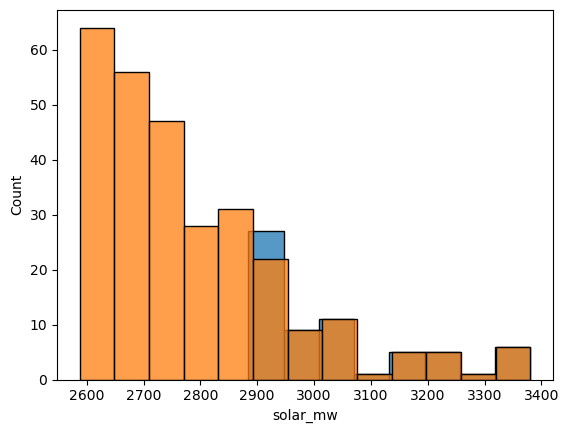

In [54]:
sns.histplot(df["solar_mw"][oz_score])
sns.histplot(df["solar_mw"][iqr_filter])

Nous pourrons noter dans la suite du travail comme outlier l'intersection des deux méthodes statistiques.

#### Gestion des valeurs manquantes

L'EDA n'a pas montré de séquences longues absentes. Pour l'instant, il a été proposé de juste raise les potentielles séquences absentes de plus de 3 heures pour analyser la qualité des données d'entrée. Les séquences de moins de 3h absentes seront interpolées de manière linéaire en première approche, avec peut-être un lissage exponentiel dans le futur.

In [26]:
#ts = ts.interpolate("linear", limit=max_gap)

def missing_sequence_detection(ts: pd.Series, max_gap: int):
    """Détecte les séries temporelles manquantes de plus de max_gap (généralement 2 ou 3 heures)

    Args:
        df (pd.DataFrame): _description_
        max_gap (np.int8): _description_
    """
    dict_sequence = {}
    is_nan = ts.isna()
    start_sequence = is_nan & (~is_nan.shift(1, fill_value=False)) #Filtre les premiers index des séquences absentes
    sequence_number = 0 #ID de la séquence manquante

    for start_idx in ts[start_sequence].index:
        
        temp_idx = start_idx
        count = 0
        
        while temp_idx in ts.index and np.isnan(ts.loc[temp_idx]):
            count +=1
            next_idx = temp_idx + pd.Timedelta("1h")
            
            if next_idx in ts.index:
                temp_idx = next_idx
            else:
                raise(IndexError)
        
        end_idx = temp_idx - pd.Timedelta("1h") #Ajustement de l'id pour être le dernier de la séquence manquante
        sequence_number += 1
        
        if count > max_gap:
            logging.info(f"Séquence absente trouvée : {start_idx, end_idx}")
            dict_sequence[sequence_number] = [start_idx, end_idx]

        return dict_sequence

In [ ]:
dict_sequence = missing_sequence_detection(df["solar_mw"], 3)
print(dict_sequence)

{1: [Timestamp('2023-02-02 17:00:00+0100', tz='Europe/Paris'), Timestamp('2023-02-03 08:00:00+0100', tz='Europe/Paris')]}


In [35]:
def interpolate_ts(df: pd.DataFrame) -> pd.DataFrame:
    """Interpole sur 3 heures maximum les colonnes du dataframe df de manière linéaire

    Args:
        df (pd.DataFrame): DataFrame d'entrée avec comme colonnes des séries temporelles

    Returns:
        pd.DataFrame: DataFrame de sortie avec interpolation sur valeurs absentes
    """
    for col in df.columns:
        df[col] = df[col].interpolate( method="linear", limit=3)

    return df

In [36]:
df = interpolate_ts(df)

#### Transformations statistiques

#### Création des features temporelles

La création de features temporelles est primordiale pour des séries saisonnières telles que la production solaire. Les features brutes telles que les mois et les heures sont difficilement interprétables par les modèles linéaires et les réseaux de neurones. Ainsi, un encodage cyclique des mois et des heures (cos, sin), permet au modèle de d'intégrer d'une part la redondance des comportements, d'autre part la similarité du comportement de Décembre (12), et Janvier (0).

In [ ]:
def cyclical_features_encoding(X: pd.DataFrame, timeframe_dict: Dict[str, int]) -> pd.DataFrame:
    
    """Encode les features cycliques dans un dataframe (df) muni d'un index temporel, par les features données dans le dictionnaire (timeframe_dict)

    Args:
        df (pd.DataFrame): DataFrame muni d'un TimeIndex
        timeframe_dict (dict): Dictionnaire muni du nom de la timeframe et de la saisonnalité associée : {"hour": 24}

    Returns:
        pd.DataFrame: DataFrame muni des colonnes temporelles cycliques (clé dictionnaire+"_cos", "clé dictionnaire"+"_sin")
    """
    df = X.copy()

    for key, item in timeframe_dict.items():
        
        df[key] =  getattr(df.index, key)
        df[f"{key}_sin"] = np.round(np.sin(2 * np.pi * df[key]/item), 5)
        df[f"{key}_cos"] = np.round(np.cos(2 * np.pi * df[key]/item), 5)

    df = df.drop(columns=list(timeframe_dict.keys()))

    return df

In [7]:
timeframe_dict = {"month":12, "hour":24}
df = cyclical_features_encoding(df, timeframe_dict)

In [8]:
df.head()

solar_mw  temperature_2m  sunshine_duration  \
2023-02-01 01:00:00+01:00       0.0           3.136                0.0   
2023-02-01 02:00:00+01:00       0.0           3.436                0.0   
2023-02-01 03:00:00+01:00       0.0           3.436                0.0   
2023-02-01 04:00:00+01:00       0.0           3.436                0.0   
2023-02-01 05:00:00+01:00       0.0           3.436                0.0   

                           is_day  relative_humidity_2m  precipitation  \
2023-02-01 01:00:00+01:00     0.0              99.29538            0.0   
2023-02-01 02:00:00+01:00     0.0              99.64800            0.0   
2023-02-01 03:00:00+01:00     0.0              99.29709            0.0   
2023-02-01 04:00:00+01:00     0.0              98.59856            0.1   
2023-02-01 05:00:00+01:00     0.0              99.29709            0.6   

                           surface_pressure  cloud_cover  wind_speed_10m  \
2023-02-01 01:00:00+01:00         974.73560        100.0        6.989936   
2023-02-01 02:00:00+01:00         974.41766        100.0        8.089994   
2023-02-01 03:00:00+01:00         974.41766        100.0        9.178235   
2023-02-01 04:00:00+01:00         974.04000        100.0        9.693296   
2023-02-01 05:00:00+01:00         974.04000        100.0       10.587918   

                           wind_direction_10m  ...  \
2023-02-01 01:00:00+01:00           304.50858  ...   
2023-02-01 02:00:00+01:00           302.27563  ...   
2023-02-01 03:00:00+01:00           281.30990  ...   
2023-02-01 04:00:00+01:00           291.80148  ...   
2023-02-01 05:00:00+01:00           305.31128  ...   

                           global_tilted_irradiance_delta_minmax  \
2023-02-01 01:00:00+01:00                                    0.0   
2023-02-01 02:00:00+01:00                                    0.0   
2023-02-01 03:00:00+01:00                                    0.0   
2023-02-01 04:00:00+01:00                                    0.0   
2023-02-01 05:00:00+01:00                                    0.0   

                           global_tilted_irradiance_std  \
2023-02-01 01:00:00+01:00                           0.0   
2023-02-01 02:00:00+01:00                           0.0   
2023-02-01 03:00:00+01:00                           0.0   
2023-02-01 04:00:00+01:00                           0.0   
2023-02-01 05:00:00+01:00                           0.0   

                           terrestrial_radiation_delta_minmax  \
2023-02-01 01:00:00+01:00                                 0.0   
2023-02-01 02:00:00+01:00                                 0.0   
2023-02-01 03:00:00+01:00                                 0.0   
2023-02-01 04:00:00+01:00                                 0.0   
2023-02-01 05:00:00+01:00                                 0.0   

                           terrestrial_radiation_std  \
2023-02-01 01:00:00+01:00                        0.0   
2023-02-01 02:00:00+01:00                        0.0   
2023-02-01 03:00:00+01:00                        0.0   
2023-02-01 04:00:00+01:00                        0.0   
2023-02-01 05:00:00+01:00                        0.0   

                           apparent_temperature_delta_minmax  \
2023-02-01 01:00:00+01:00                             9.2179   
2023-02-01 02:00:00+01:00                             8.8490   
2023-02-01 03:00:00+01:00                             6.6066   
2023-02-01 04:00:00+01:00                             5.0427   
2023-02-01 05:00:00+01:00                             5.8898   

                           apparent_temperature_std  month_sin  month_cos  \
2023-02-01 01:00:00+01:00                    2.4873    0.86603        0.5   
2023-02-01 02:00:00+01:00                    2.3038    0.86603        0.5   
2023-02-01 03:00:00+01:00                    1.9406    0.86603        0.5   
2023-02-01 04:00:00+01:00                    1.7014    0.86603        0.5   
2023-02-01 05:00:00+01:00                    1.7487    0.86603        0.5   

               

In [9]:
def lagged_ma_feature_encoding(df: pd.DataFrame, feature_list: list[str], lag_list: list[int]) -> pd.DataFrame:
    
    """Prends en entrée un DataFrame df indexée temporellement avec une liste de features (feature_list) et de lags (lag_list), et renvoie le dataframe df munie des features laggées et
    d'une moyenne mobile sur les mêmes lags.

    Args:
        df (pd.DataFrame): DataFrame indexé temporellement
        feature_list (list[str]): Features (noms de colonnes du dataframe) que l'on veut retarder ou lisser.
        lag_list (list[int]): Liste de lags à imputer

    Returns:
        pd.DataFrame: Retourne le DataFrame munie des features laggées et les moyennes mobiles associées
    """

    for col in feature_list:
        for lag in lag_list:
            #Feature laggée
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
            #Moyenne mobile sur lag période
            df[f"{col}_ma_{lag}"] = df[col].rolling(window=lag).mean()
    
    df = df.dropna()
    
    return df

In [10]:
# Lags irradiance, humidité, vitesse du vent et température
lag_list = [24, 32, 48]
feature_list =['global_tilted_irradiance',  'relative_humidity_2m', 'temperature_2m', 'wind_speed_10m']
df = lagged_ma_feature_encoding(df, feature_list, lag_list)

In [11]:
df.head()

solar_mw  temperature_2m  sunshine_duration  \
2023-02-03 01:00:00+01:00       0.0           0.686                0.0   
2023-02-03 02:00:00+01:00       0.0          -0.564                0.0   
2023-02-03 03:00:00+01:00       0.0          -1.364                0.0   
2023-02-03 04:00:00+01:00       0.0          -1.264                0.0   
2023-02-03 05:00:00+01:00       0.0          -1.464                0.0   

                           is_day  relative_humidity_2m  precipitation  \
2023-02-03 01:00:00+01:00     0.0             95.755350            0.0   
2023-02-03 02:00:00+01:00     0.0             98.912430            0.0   
2023-02-03 03:00:00+01:00     0.0             99.268974            0.0   
2023-02-03 04:00:00+01:00     0.0             99.269585            0.0   
2023-02-03 05:00:00+01:00     0.0             98.904350            0.0   

                           surface_pressure  cloud_cover  wind_speed_10m  \
2023-02-03 01:00:00+01:00         977.92096         95.0        3.259939   
2023-02-03 02:00:00+01:00         977.47500         58.0        2.902413   
2023-02-03 03:00:00+01:00         977.30927        100.0        1.800000   
2023-02-03 04:00:00+01:00         977.04694        100.0        0.720000   
2023-02-03 05:00:00+01:00         976.91080          1.0        1.138420   

                           wind_direction_10m  ...  temperature_2m_lag_32  \
2023-02-03 01:00:00+01:00           173.65990  ...                  5.786   
2023-02-03 02:00:00+01:00           150.25520  ...                  4.436   
2023-02-03 03:00:00+01:00           126.86999  ...                  2.936   
2023-02-03 04:00:00+01:00            90.00000  ...                  1.836   
2023-02-03 05:00:00+01:00           108.43504  ...                  1.336   

                           temperature_2m_ma_32  temperature_2m_lag_48  \
2023-02-03 01:00:00+01:00              1.750063                  3.136   
2023-02-03 02:00:00+01:00              1.593813                  3.436   
2023-02-03 03:00:00+01:00              1.459438                  3.436   
2023-02-03 04:00:00+01:00              1.362563                  3.436   
2023-02-03 05:00:00+01:00              1.275063                  3.436   

                           temperature_2m_ma_48  wind_speed_10m_lag_24  \
2023-02-03 01:00:00+01:00              2.613083               9.686609   
2023-02-03 02:00:00+01:00              2.529750               4.829907   
2023-02-03 03:00:00+01:00              2.429750               4.379589   
2023-02-03 04:00:00+01:00              2.331833               3.976330   
2023-02-03 05:00:00+01:00              2.229750               4.320000   

                           wind_speed_10m_ma_24  wind_speed_10m_lag_32  \
2023-02-03 01:00:00+01:00              7.660895              15.459054   
2023-02-03 02:00:00+01:00              7.580583              12.879752   
2023-02-03 03:00:00+01:00              7.473100              10.009036   
2023-02-03 04:00:00+01:00              7.337419               7.704336   
2023-02-03 05:00:00+01:00              7.204854               7.568566   

                           wind_speed_10m_ma_32  wind_speed_10m_lag_48  \
2023-02-03 01:00:00+01:00              7.823155               6.989936   
2023-02-03 02:00:00+01:00              7.511363               8.089994   
2023-02-03 03:00:00+01:00              7.254831               9.178235   
2023-02-03 04:00:00+01:00              7.036570               9.693296   
2023-02-03 05:00:00+01:00              6.835628              10.587918   

                           wind_speed_10m_ma_48  
2023-02-03 01:00:00+01:00              9.771854  
2023-02-03 02:00:00+01:00              9.663779  
2023-02-03 03:00:00+01:00              9.510066  
2023-02-03 04:00:00+01:00              9.323122  
2023-02-03 05:00:00+01:00              9.126258  

[5 rows x 77 columns]